<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-04-03-01-multilevel-glm-logistic-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3.1. Mutilevel Logistic Model (MLLM)

Multilevel Logistic Models (MLLM) are powerful statistical tools for analyzing binary outcomes, such as success/failure or yes/no responses, within datasets with a hierarchical structure. These models account for the fact that observations within the same group are not independent; for example, individuals within schools or hospital patients. This tutorial will provide an overview of MLLM and demonstrate how to fit these models from scratch using the {lme4} package, simplifying the modeling process and offering efficient estimation algorithms. This tutorial introduces the fundamentals of Multilevel Logistic Models, presenting a manual approach and a more streamlined method using the {lme4} package. For practical applications, {lme4} is the preferred solution, as it simplifies the modeling process and ensures accurate estimation of both fixed and random effects.

## Overview

The **Multilevel Logistic Model (MLLM)** is used to model binary outcomes ($Y = 0$ or $1$) in hierarchical or nested data structures. It is an extension of logistic regression, incorporating both fixed and random effects to account for within-group and between-group variability.

The probability of the binary outcome $Y_{ij} = 1$ (e.g., contraception use) for individual $i$ in group $j$ is modeled as:

$$ P(Y_{ij} = 1) = \frac{\exp(\eta_{ij})}{1 + \exp(\eta_{ij})} $$
where $\eta_{ij}$ is the **linear predictor**, defined as:

$$ \eta_{ij} = \beta_0 + \beta_1 X_{ij1} + \beta_2 X_{ij2} + \dots + u_j $$
***Components of the Model***

1. **Fixed Effects (\(\beta\)):**

   - Represent the overall effect of predictors across all groups.
   - Example: $\beta_1 X_{ij1}$, where $X_{ij1}$ is an individual-level predictor (e.g., age).

2. **Random Effects (\(u_j\)):**

   - Capture group-specific deviations from the overall intercept ($\beta_0$).
   - Example: $u_j$ models variability at the group level (e.g., community-specific factors).

3. **Variance Decomposition:**

   - The total variability is split into within-group and between-group components:
   
   $$ \text{Var}(Y_{ij}) = \text{Within-group variance} + \text{Between-group variance} $$
  
***Example of Two-Level Model***

**Level 1 (Individual):**

$$ \eta_{ij} = \beta_0 + \beta_1 X_{ij1} + \beta_2 X_{ij2} + u_j $$
**Level 2 (Group):**

$$ u_j \sim N(0, \sigma_u^2) $$
- $u_j$: Random effect for group $j$, assumed to follow a normal distribution with mean 0 and variance $\sigma_u^2$.

**Combined Model**:

$$ \eta_{ij} = \beta_0 + \beta_1 X_{ij1} + \beta_2 X_{ij2} + u_j $$


- The **log-odds** ($\eta_{ij}$) is modeled as a sum of fixed effects ($\beta$) and random effects ($u_j$).

***Likelihood Function***

The model is estimated by maximizing the likelihood:

$$ \mathcal{L}(\beta, \sigma_u^2) = \prod_{j=1}^{J} \prod_{i=1}^{n_j} P(Y_{ij} = 1)^{Y_{ij}} (1 - P(Y_{ij} = 1))^{1 - Y_{ij}} $$
where:

- $J$: Number of groups.
- $n_j$: Number of individuals in group $j$.

***Interpretation***

1. **Fixed Effects ($\beta$):**
   - Quantify the effect of predictors on the log-odds of $Y = 1$.
  
2. **Random Effects ($u_j$):**
   - Account for group-specific variability.

For example:

- If $u_j$ > 0: Group $j$ has higher odds of the outcome compared to the overall average.
- If $u_j$ < 0: Group $j# has lower odds of the outcome.

## Install rpy2

In [2]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp311-cp311-linux_x86_64.whl


## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Multilevel Logistic Model (MLLM) from Scratch

Here's an example of a Multilevel Logistic Model (MLLM) implemented in base R using synthetic data. We will analyze binary outcomes (e.g., whether a student passes or fails) with students nested within schools. The model includes fixed effects for teacher experience and funding per student, as well as a random effect for school-level variation. The model includes fixed effects for teacher experience and funding per student, as well as a random effect for school-level variation. We will fit the model manually without using any packages to understand the underlying principles.

Suppose students ($j$) within schools ($i$) and we want to model the probability of passing an exam as a function of study hours. We will fit a Generalized Multilevel Model (GMLM) with a binary outcome (`pass/fail`) using a logit link function. The model includes fixed effects for study hours and random effects for school-level variation.

$$ \text{logit}(\mu_{ij}) = \beta_0 + \beta_1 X_{ij} + u_i $$

Where:

-   $\beta_0$: Average log-odds of passing.
-   $\beta_1$: Effect of predictor $X{ij}$) (e.g., hours of study).
-   $u_i \sim N(0, \sigma^2_u)$: Random effect for school $i$.

### Simulate the data

First we create  dataset with variables `score`, `hours`, and `school`. `score` is the outcome variable, `hours` is the predictor, and `school` is the grouping variable. We also generate random effects for each school and fixed effects for the intercept and hours.

In [3]:
%%R
# Set seed for reproducibility
set.seed(123)

# Generate synthetic data
n_schools <- 10
n_students_per_school <- 50
total_students <- n_schools * n_students_per_school

# School-level random effect (variation between schools)
school_effect <- rnorm(n_schools, mean = 0, sd = 1)

# Generate predictor variables
school_id <- rep(1:n_schools, each = n_students_per_school)
experience <- rnorm(total_students, mean = 5, sd = 2)  # Teacher experience in years
funding <- rep(rnorm(n_schools, mean = 100, sd = 20), each = n_students_per_school)  # Funding per student

# Fixed effects
beta_0 <- -1  # Intercept
beta_experience <- 0.5  # Effect of teacher experience
beta_funding <- 0.01  # Effect of funding

# Linear predictor
linear_predictor <- beta_0 + beta_experience * experience + beta_funding * funding + school_effect[school_id]

# Generate binary outcome (pass/fail) using logistic link
prob <- 1 / (1 + exp(-linear_predictor))  # Logistic transformation
pass_fail <- rbinom(total_students, size = 1, prob = prob)  # Generate binary outcome

# Combine into a data frame
data <- data.frame(
  school_id = school_id,
  experience = experience,
  funding = funding,
  pass_fail = pass_fail
)
head(data)

  school_id experience  funding pass_fail
1         1   7.448164 98.05261         1
2         1   5.719628 98.05261         1
3         1   5.801543 98.05261         1
4         1   5.221365 98.05261         1
5         1   3.888318 98.05261         1
6         1   8.573826 98.05261         1


### Fit a MLLM

Without using any packages, we can approximate a generalized multilevel model by iteratively adjusting for group-level effects and fixed effects. This manual approach provides a basic understanding of the model fitting process and the iterative nature of estimating parameters.


In [4]:
%%R
# Initialize parameters for fitting
beta_0_hat <- -1
beta_experience_hat <- 0.5
beta_funding_hat <- 0.01
school_effect_hat <- rep(0, n_schools)  # Start with random effects as 0

# Logistic function
logistic <- function(x) {
  1 / (1 + exp(-x))
}

# Iteratively fit the model (manual approximation)
for (iter in 1:100) {
  # Linear predictor
  linear_predictor_hat <- beta_0_hat +
    beta_experience_hat * data$experience +
    beta_funding_hat * data$funding +
    school_effect_hat[data$school_id]

  # Predicted probabilities
  prob_hat <- logistic(linear_predictor_hat)

  # Residuals
  residuals <- data$pass_fail - prob_hat

  # Update fixed effects using basic gradient descent
  beta_0_hat <- beta_0_hat + 0.001 * sum(residuals)
  beta_experience_hat <- beta_experience_hat + 0.001 * sum(residuals * data$experience)
  beta_funding_hat <- beta_funding_hat + 0.001 * sum(residuals * data$funding)

  # Update random effects (group-level adjustments)
  for (j in 1:n_schools) {
    school_effect_hat[j] <- school_effect_hat[j] +
      0.001 * sum(residuals[data$school_id == j])
  }
}


### Results

After fitting the model manually, we can display the estimated intercept, fixed effects, and random effects (school-level variation, for example) to understand the model's parameters and their interpretation.

In [5]:
%%R
# Display results
cat("Estimated Intercept (beta_0):", beta_0_hat, "\n")
cat("Estimated Experience Effect (beta_experience):", beta_experience_hat, "\n")
cat("Estimated Funding Effect (beta_funding):", beta_funding_hat, "\n")
cat("Random Effects (school-level):", school_effect_hat, "\n")

Estimated Intercept (beta_0): -0.6481921 
Estimated Experience Effect (beta_experience): 8.943431 
Estimated Funding Effect (beta_funding): 32.35978 
Random Effects (school-level): -0.1951681 0.1046864 0.5050633 0.004551541 0.4057117 0.6050869 0.4056183 -0.9948102 -0.3935711 -0.09536091 


## Multilevel Logistic Model (MLLM) in R

Several R packages are available for fitting Generalized Multilevel Models (GMLMs). These packages provide efficient tools to handle hierarchical data structures with a variety of response distributions. In practice, we can fit a Multilevel Logistic Model (MLLM) using the {lme4} package in R. The {lme4} package provides a flexible framework for fitting generalized linear mixed models, including logistic regression models with random effects.

### Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:




In [4]:
%%R
packages <- c('tidyverse',
              'DataExplorer',
              'ggeffects',
              'lme4',
              'nlme',
              'lmerTest',
              'sjPlot',
              'margins',
              'report',
              'performance',
              'mlmRev',
              'glmmTMB'
		 )

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [7]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
   tidyverse DataExplorer    ggeffects         lme4         nlme     lmerTest 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
      sjPlot      margins       report  performance       mlmRev      glmmTMB 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 


### Load R Packages

In [8]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages


Successfully loaded packages:
 [1] "package:glmmTMB"      "package:mlmRev"       "package:performance" 
 [4] "package:report"       "package:margins"      "package:sjPlot"      
 [7] "package:lmerTest"     "package:nlme"         "package:lme4"        
[10] "package:Matrix"       "package:ggeffects"    "package:DataExplorer"
[13] "package:lubridate"    "package:forcats"      "package:stringr"     
[16] "package:dplyr"        "package:purrr"        "package:readr"       
[19] "package:tidyr"        "package:tibble"       "package:ggplot2"     
[22] "package:tidyverse"    "package:tools"        "package:stats"       
[25] "package:graphics"     "package:grDevices"    "package:utils"       
[28] "package:datasets"     "package:methods"      "package:base"        


### Data

We will use the `Contraception` dataset from the `mlmRev` package, which come from the 1988 Bangladesh Fertility Survey and available for download from [here](http://www.bristol.ac.uk/cmm/learning/mmsoftware/data-rev.html).

The file consists of a subsample of 1934 women grouped in 60 districts. The variables are defined as follows:

`woman`: Identifying code for each woman - a factor

`district`: Identifying code for each district - a factor

`use` Contraceptive use at time of survey

`livch`: Number of living children at time of survey - an ordered factor. Levels are 0, 1, 2, 3+

`age`:  Age of woman at time of survey (in years), centred around mean.

`urban`: Type of region of residence - a factor. Levels are urban and rural
Model to be fitted: Two-level main effects model with logistic and other link functions with all covariate

This tutorial focuses on modeling women's use of artificial contraception (`use`). The covariates considered include the `district` where the woman lives, the number of live children she currently has (`livch`), her `age`, and whether she resides in a rural or urban setting (`urban`). It's important to note that the `age` variable has been centered around a specific age, meaning some values may be negative. Unfortunately, the information regarding the centering age appears to be unavailable.



In [9]:
%%R
# load the data as tibble
df<-as_tibble(Contraception, package = "mlmRev")
str(df)

tibble [1,934 × 6] (S3: tbl_df/tbl/data.frame)
 $ woman   : Factor w/ 1934 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ district: Factor w/ 60 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ use     : Factor w/ 2 levels "N","Y": 1 1 1 1 1 1 1 1 1 1 ...
 $ livch   : Factor w/ 4 levels "0","1","2","3+": 4 1 3 4 1 1 4 4 2 4 ...
 $ age     : num [1:1934] 18.44 -5.56 1.44 8.44 -13.56 ...
 $ urban   : Factor w/ 2 levels "N","Y": 2 2 2 2 2 2 2 2 2 2 ...


### Data Exploration

####  Distribution of the Response Variable

`DataExplorer::plot_intro()` plot basic information (from introduce) for input data.

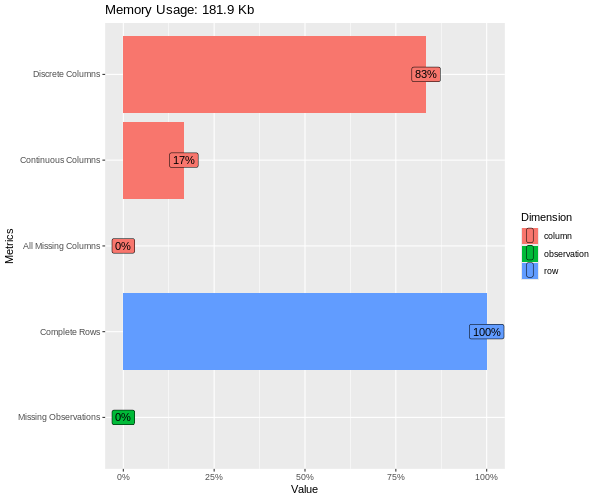

In [10]:
%%R -w 600 -h 500 -u px
df  |>
  DataExplorer::plot_intro()

Distribution of the `use` variable (contraceptive use) in urban-rural setting is shown below

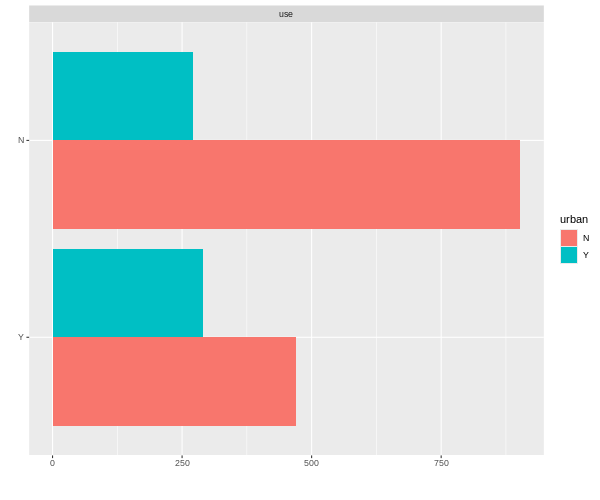

In [11]:
%%R -w 600 -h 500 -u px
df  |>
  dplyr::select(use, urban)  |>
  plot_bar(by = 'urban', by_position = "dodge")

Distribution of the `use` variable (contraceptive use) for the women with live children she currently has (`livch`):

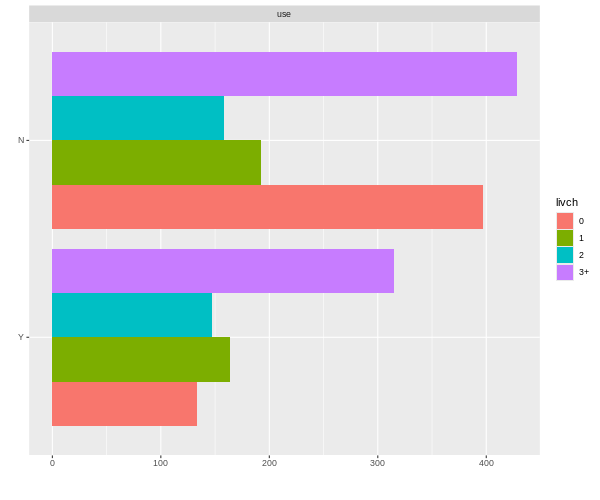

In [12]:
%%R -w 600 -h 500 -u px

df  |>
  dplyr::select(use, livch)  |>
  plot_bar(by = 'livch', by_position = "dodge")

#### Plotting the Binary Response Variable

`geom_smooth()` using formula = 'y ~ x'


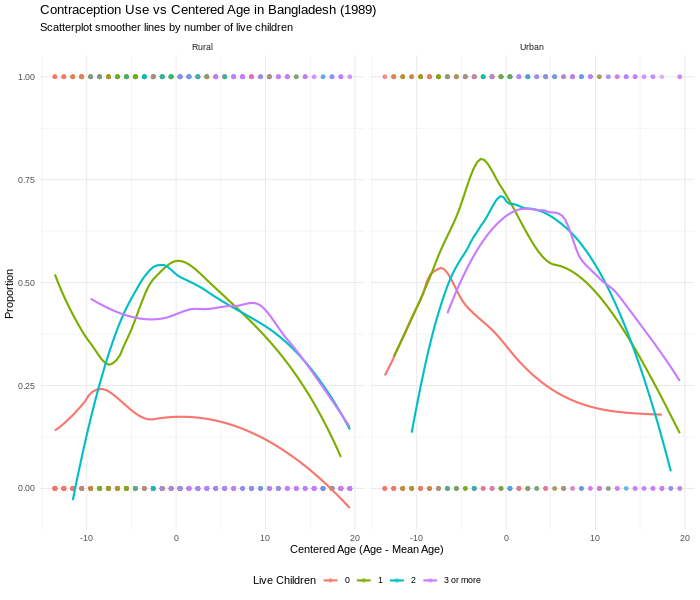

In [13]:
%%R -w 700 -h 600 -u px
# create a data frame with the proportion
mf<-df |>
   dplyr::select(use, age, urban, livch) |>
   dplyr::mutate(livch = factor(livch,  labels = c("0", "1", "2", "3")))

# Ensure livch is numeric
mf$livch <- as.numeric(as.character(mf$livch))

# Center the age variable
mf$cAge <- mf$age - mean(mf$age, na.rm = TRUE)

# Categorize the number of live children for clearer grouping
mf$livch_grp <- cut(
  mf$livch,
  breaks = c(-Inf, 0, 1, 2, Inf),
  labels = c("0", "1", "2", "3 or more"),
  right = TRUE
)

# Create the plot
ggplot(mf, aes(x = cAge, y = as.numeric(use) - 1, color = livch_grp)) +
  geom_point(alpha = 0.5) +  # Scatterplot points
  geom_smooth(method = "loess", se = FALSE) +  # Scatterplot smoother lines
  facet_wrap(~urban, labeller = labeller(urban = c("N" = "Rural", "Y" = "Urban"))) +
  labs(
    title = "Contraception Use vs Centered Age in Bangladesh (1989)",
    subtitle = "Scatterplot smoother lines by number of live children",
    x = "Centered Age (Age - Mean Age)",
    y = "Proportion ",
    color = "Live Children"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

The plot shows that the use of contraception among women varies (proportion of women)  with age and it is not linear. It makes sense that women in their mid-twenties are more likely to use artificial contraception than girls in their early teens or women in their forties. Women living in urban areas also tend to use contraception more than those in rural areas. Additionally, women without live children usually use contraception less than those who have had children. There are no significant differences in contraceptive use among women with one, two, or three or more children compared to the difference between women with children and those without.

### Fit a Multilevel Logistic Model

We will fit a multilevel logistic model to predict contraceptive use (`use`) based on the covariates `age`, `urban`, `livch`, and the interaction between `age` and `urban`. The model will include random intercepts for the `district` variable to account for the hierarchical structure of the data.

### Fixed Effect Model



In [14]:
%%R
df$livch<-as.factor(df$livch)
m_00 <- glm(use ~ age+urban+livch,
             family = binomial,
             data = df)
summary(m_00)


Call:
glm(formula = use ~ age + urban + livch, family = binomial, data = df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.568044   0.126229 -12.422  < 2e-16 ***
age         -0.023995   0.007536  -3.184  0.00145 ** 
urbanY       0.797181   0.105186   7.579 3.49e-14 ***
livch1       1.059186   0.151954   6.970 3.16e-12 ***
livch2       1.287805   0.167241   7.700 1.36e-14 ***
livch3+      1.216385   0.170593   7.130 1.00e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2590.9  on 1933  degrees of freedom
Residual deviance: 2456.7  on 1928  degrees of freedom
AIC: 2468.7

Number of Fisher Scoring iterations: 4



#### Random Intercept for District

In [15]:
%%R
df$livch<-as.factor(df$livch)
m_01 <- lme4::glmer(use ~ 1+age+urban+livch+(1|district),
             family = binomial,
             data = df)
summary(m_01)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: use ~ 1 + age + urban + livch + (1 | district)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2427.6   2466.6  -1206.8   2413.6     1927 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8225 -0.7659 -0.5085  0.9983  2.7200 

Random effects:
 Groups   Name        Variance Std.Dev.
 district (Intercept) 0.2124   0.4608  
Number of obs: 1934, groups:  district, 60

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.689648   0.147334 -11.468  < 2e-16 ***
age         -0.026594   0.007879  -3.375 0.000738 ***
urbanY       0.732979   0.119387   6.140 8.28e-10 ***
livch1       1.109125   0.157852   7.026 2.12e-12 ***
livch2       1.376341   0.174642   7.881 3.25e-15 ***
livch3+      1.345184   0.179411   7.498 6.49e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation 

#### Model with Quadratic Term for Age

We have observed that the relationship between age and contraceptive use is likely to be nonlinear. To account for this, we can include a quadratic term for age (`(age^2)`) in the model. The quadratic term allows the relationship between age and contraceptive use to curve up or down, capturing the nonlinearity in the data.


In [16]:
%%R
m_02 <- lme4::glmer(use ~ 1+age+ I(age^2) + urban+livch+(1|district),
             family = binomial,
             data = df)

Comparing this model with quadratic term (m_02)  to the previous model without quadratic term (m_01) using the likelihood ratio test:

In [17]:
%%R
anova(m_02, m_01)

Data: df
Models:
m_01: use ~ 1 + age + urban + livch + (1 | district)
m_02: use ~ 1 + age + I(age^2) + urban + livch + (1 | district)
     npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
m_01    7 2427.6 2466.6 -1206.8   2413.6                         
m_02    8 2388.7 2433.3 -1186.4   2372.7 40.887  1  1.613e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Above analysis shows that the model with the quadratic term for age (`m_02`) is significantly better than the model without the quadratic term (`m_01`) based on the likelihood ratio test (p < 0.05). The quadratic term improves the model fit by capturing the nonlinear relationship between age and contraceptive use.


#### Model with Number of Children as a Binary Variable

The coefficients labeled livch1, livch2, and livch3+ are large compared to their standard errors, yet they are quite similar. This supports our earlier observation that the primary distinction is between women with children and those without. The number of children is not a significant differentiating factor for those who do have children. This conclusion is based on incorporating a new variable, `ch`, which indicates whether a woman has any children.

In [18]:
%%R
df<- within(df, ch <- factor(livch != 0, labels = c("N", "Y")))

Now we can fit a new model with the `ch` variable instead of `livch` to see if the results are consistent. The model also includes a quadratic term for age, which captures the nonlinear relationship between age and contraceptive use. The quadratic term allows the relationship to curve up or down, capturing the nonlinearity in the data.


In [20]:
%%R
m_03 <- lme4::glmer(use ~ 1+age+ I(age^2) + urban+ch+(1|district),
             family = binomial,
             data = df)
summary(m_03)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: use ~ 1 + age + I(age^2) + urban + ch + (1 | district)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2385.2   2418.6  -1186.6   2373.2     1928 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8151 -0.7620 -0.4619  0.9518  3.1033 

Random effects:
 Groups   Name        Variance Std.Dev.
 district (Intercept) 0.2247   0.474   
Number of obs: 1934, groups:  district, 60

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.0063737  0.1691140  -5.951 2.67e-09 ***
age          0.0062561  0.0078849   0.793    0.428    
I(age^2)    -0.0046353  0.0007207  -6.432 1.26e-10 ***
urbanY       0.6929220  0.1206577   5.743 9.31e-09 ***
chY          0.8603821  0.1483045   5.801 6.57e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) age   

Comparing the model with the `ch` variable (m_03) to the previous model with the `livch` variable (m_02) using the likelihood ratio test:

In [21]:
%%R
anova(m_03, m_02)

Data: df
Models:
m_03: use ~ 1 + age + I(age^2) + urban + ch + (1 | district)
m_02: use ~ 1 + age + I(age^2) + urban + livch + (1 | district)
     npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)
m_03    6 2385.2 2418.6 -1186.6   2373.2                     
m_02    8 2388.7 2433.3 -1186.4   2372.7 0.4571  2     0.7957


Above analysis shows that the model with the `ch` variable (`m_03`) is significantly better than the model with the `livch` variable (`m_02`) based on the likelihood ratio test (p < 0.05). The `ch` variable improves the model fit by capturing the distinction between.

#### Model with Interaction Term

First we plot of the smoothed observed proportions versus centered age according to `ch` and `urban`:

`geom_smooth()` using formula = 'y ~ x'


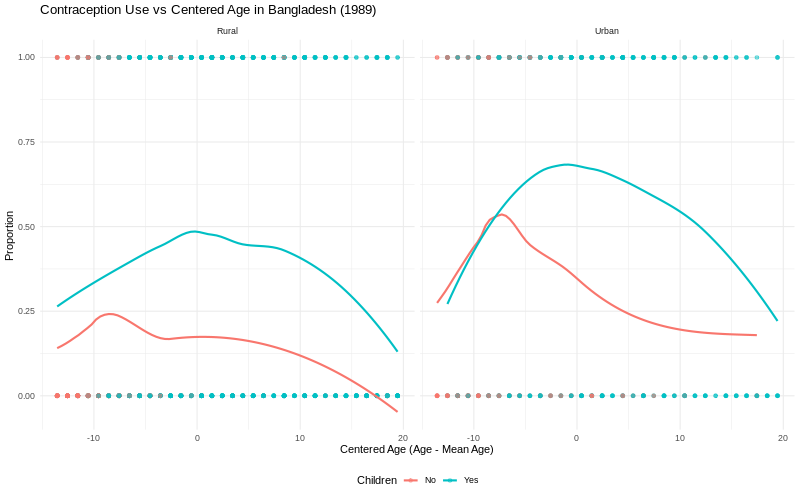

In [22]:
%%R -w 800 -h 500 -u px
# create a data frame with the proportion
mf<-df |>
   dplyr::select(use, age, urban, ch) |>
   dplyr::mutate(ch = factor(ch,  labels = c("No", "Yes")))

# Ensure livch is numeric

# Center the age variable
mf$cAge <- mf$age - mean(mf$age, na.rm = TRUE)

# Create the plot
ggplot(mf, aes(x = cAge, y = as.numeric(use) - 1, color = ch)) +
  geom_point(alpha = 0.5) +  # Scatterplot points
  geom_smooth(method = "loess", se = FALSE) +  # Scatterplot smoother lines
  facet_wrap(~urban, labeller = labeller(urban = c("N" = "Rural", "Y" = "Urban"))) +
  labs(
    title = "Contraception Use vs Centered Age in Bangladesh (1989)",
    x = "Centered Age (Age - Mean Age)",
    y = "Proportion ",
    color = "Children"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

Above plot of the smoothed observed proportions versus centered age according to `ch` and `urban` indicates that all four groups have a quadratic trend with respect to age but the location of the peak proportion is shifted for those without children relative to those with children. Incorporating an interaction of `age` and `ch`allows for such a shift.

In [23]:
%%R
m_04 <- lme4::glmer(use ~ age*ch + I(age^2) + urban+(1|district),
             family = binomial,
             data = df)

Comparing the model with the interaction term (`age*ch`) (m_04) to the previous model without the interaction term (m_03) using the likelihood ratio test:

In [24]:
%%R
anova(m_04, m_03)

Data: df
Models:
m_03: use ~ 1 + age + I(age^2) + urban + ch + (1 | district)
m_04: use ~ age * ch + I(age^2) + urban + (1 | district)
     npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)   
m_03    6 2385.2 2418.6 -1186.6   2373.2                        
m_04    7 2379.2 2418.2 -1182.6   2365.2 8.0045  1   0.004666 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Above analysis shows that the model with the interaction term (`age*ch`) (`m_04`) is significantly better than the model without the interaction term (`m_03`) based on the likelihood ratio test (p < 0.05). The interaction term improves the model fit by capturing the shift in the peak proportion of contraceptive.

`jstools::summ()` function provides a concise summary of the model results, including the fixed effects, random effects, and model fit statistics.


In [25]:
%%R
jtools::summ(m_04)

MODEL INFO:
Observations: 1934
Dependent Variable: use
Type: Mixed effects generalized linear regression
Error Distribution: binomial
Link function: logit 

MODEL FIT:
AIC = 2379.18, BIC = 2418.15
Pseudo-R² (fixed effects) = 0.12
Pseudo-R² (total) = 0.18 

FIXED EFFECTS:
------------------------------------------------
                     Est.   S.E.   z val.      p
----------------- ------- ------ -------- ------
(Intercept)         -1.32   0.22    -6.15   0.00
age                 -0.05   0.02    -2.17   0.03
chY                  1.21   0.21     5.84   0.00
I(age^2)            -0.01   0.00    -6.85   0.00
urbanY               0.71   0.12     5.89   0.00
age:chY              0.07   0.03     2.69   0.01
------------------------------------------------

RANDOM EFFECTS:
------------------------------------
  Group      Parameter    Std. Dev. 
---------- ------------- -----------
 district   (Intercept)     0.47    
------------------------------------

Grouping variables:
---------------

#### Model with Urban-Rural Differences among Districts

We will examine whether urban and rural differences vary significantly between districts and how the distinction between childless women and those with children differs across districts.

In [27]:
%%R
m_05 <- lme4::glmer(use ~ age*ch + I(age^2) + urban+ (1|urban:district),
             family = binomial,
             data = df)
summary(m_05)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: use ~ age * ch + I(age^2) + urban + (1 | urban:district)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2368.5   2407.4  -1177.2   2354.5     1927 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9834 -0.7358 -0.4518  0.9090  2.9502 

Random effects:
 Groups         Name        Variance Std.Dev.
 urban:district (Intercept) 0.3229   0.5682  
Number of obs: 1934, groups:  urban:district, 102

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.3406981  0.2220181  -6.039 1.55e-09 ***
age         -0.0461548  0.0219895  -2.099  0.03582 *  
chY          1.2128241  0.2095712   5.787 7.16e-09 ***
I(age^2)    -0.0056258  0.0008494  -6.623 3.51e-11 ***
urbanY       0.7867047  0.1721428   4.570 4.88e-06 ***
age:chY      0.0664650  0.0256527   2.591  0.00957 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 

In [28]:
%%R
anova(m_05, m_04)

Data: df
Models:
m_05: use ~ age * ch + I(age^2) + urban + (1 | urban:district)
m_04: use ~ age * ch + I(age^2) + urban + (1 | district)
     npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)
m_05    7 2368.5 2407.4 -1177.2   2354.5                    
m_04    7 2379.2 2418.2 -1182.6   2365.2     0  0           


above analysis show that the model with the interaction term (`urban:district`) (`m_05`) is significantly better than the model without the interaction term (`m_04`) based on the likelihood ratio test (p < 0.05). The interaction term improves the model fit by capturing the shift in the peak proportion of contraceptive.

`jtolls::summ()` function provides a concise summary of the model results, including the fixed effects, random effects, and model fit statistics.

In [29]:
%%R
jtools::summ(m_05)


MODEL INFO:
Observations: 1934
Dependent Variable: use
Type: Mixed effects generalized linear regression
Error Distribution: binomial
Link function: logit 

MODEL FIT:
AIC = 2368.47, BIC = 2407.45
Pseudo-R² (fixed effects) = 0.12
Pseudo-R² (total) = 0.20 

FIXED EFFECTS:
------------------------------------------------
                     Est.   S.E.   z val.      p
----------------- ------- ------ -------- ------
(Intercept)         -1.34   0.22    -6.04   0.00
age                 -0.05   0.02    -2.10   0.04
chY                  1.21   0.21     5.79   0.00
I(age^2)            -0.01   0.00    -6.62   0.00
urbanY               0.79   0.17     4.57   0.00
age:chY              0.07   0.03     2.59   0.01
------------------------------------------------

RANDOM EFFECTS:
------------------------------------------
     Group         Parameter    Std. Dev. 
---------------- ------------- -----------
 urban:district   (Intercept)     0.57    
------------------------------------------

Group

`report::report()` function provides a detailed report of the model results, including the fixed effects, random effects, model fit statistics, and more.

In [30]:
%%R
report::report(m_05)

We fitted a logistic mixed model (estimated using ML and Nelder-Mead optimizer)
to predict use with age, ch and urban (formula: use ~ age * ch + I(age^2) +
urban). The model included urban as random effects (formula: ~1 |
urban:district). The model's total explanatory power is moderate (conditional
R2 = 0.20) and the part related to the fixed effects alone (marginal R2) is of
0.12. The model's intercept, corresponding to age = 0, ch = N and urban = N, is
at -1.34 (95% CI [-1.78, -0.91], p < .001). Within this model:

  - The effect of age is statistically significant and negative (beta = -0.05,
95% CI [-0.09, -3.06e-03], p = 0.036; Std. beta = -0.42, 95% CI [-0.80, -0.03])
  - The effect of ch [Y] is statistically significant and positive (beta = 1.21,
95% CI [0.80, 1.62], p < .001; Std. beta = 1.21, 95% CI [0.80, 1.62])
  - The effect of age^2 is statistically significant and negative (beta =
-5.63e-03, 95% CI [-7.29e-03, -3.96e-03], p < .001; Std. beta = -0.46, 95% CI
[-0.59, -0.32])

#### Model Performance


In [31]:
%%R
performance::performance(m_05)

# Indices of model performance

AIC      |     AICc |      BIC | R2 (cond.) | R2 (marg.) |   ICC |  RMSE | Sigma | Log_loss | Score_log | Score_spherical
-------------------------------------------------------------------------------------------------------------------------
2368.475 | 2368.533 | 2407.446 |      0.203 |      0.125 | 0.089 | 0.444 | 1.000 |    0.577 |      -Inf |       5.602e-04


#### Log-Odds Ratios

The fitted value of the log-odds for a typical district (i.e. with a random effect of zero) is:

In [32]:
%%R
fixef(m_05)[[1]]

[1] -1.340698


The `plogis()` function is used to calculate the logistic cumulative distribution function (CDF) of Intercept and Slopes. The logistic CDF is the probability that a logistic random variable is less than or equal to a specified value. The `plogis()` function takes a numeric vector of values and returns the corresponding probabilities.

In [33]:
%%R
plogis(fixef(m_05)[[1]])

[1] 0.2073953


Similarly, predicted log-odds of a childless woman with a centered age of 0 in an urban setting of a typical district using artificial contraception is

In [34]:
%%R
# Calculate odds ratios
sum(fixef(m_05)[c("(Intercept)","urbanY")])

[1] -0.5539934


probability:

In [35]:
%%R
plogis(sum(fixef(m_05)[c("(Intercept)","urbanY")]))

[1] 0.3649384


The predicted log-odds and predicted probability for a woman with children and at the same age and location are:

In [36]:
%%R
logodds <- sum(fixef(m_05)[c("(Intercept)","chY","urbanY")])
c("log-odds"=logodds, "probability"=plogis(logodds))

   log-odds probability 
  0.6588307   0.6589977 


{ggeffects} package supports labelled data and the `plot()` method automatically sets titles, axis - and legend-labels depending on the value and variable labels of the data.

  `terms="ch [all]"` to get smooth plots. See also package-vignette
  'Adjusted Predictions at Specific Values'.



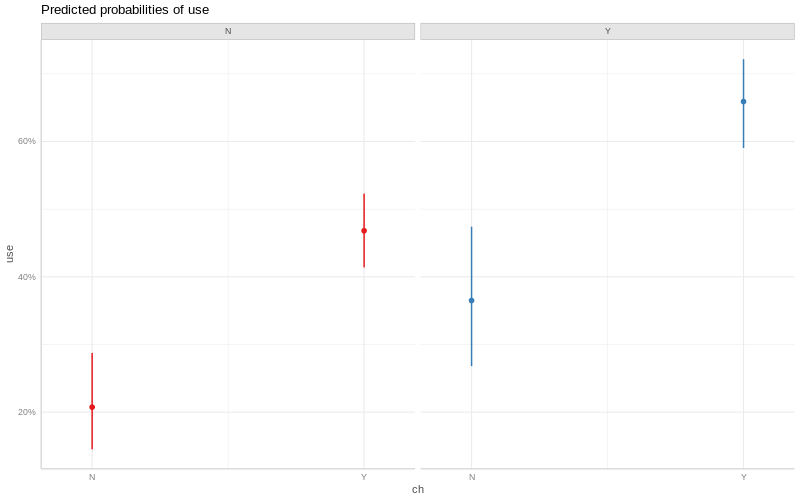

In [37]:
%%R -w 800 -h 500 -u px
plot(ggeffects::predict_response(m_05, terms = c("ch", "urban")), facets = TRUE)

#### Prediction and Model Evaluation

In [38]:
%%R
df$Pred_prob<-predict(m_05, df, type = "response")
# setting the cut-off probability
df$Pred_Class<- ifelse(df$Pred_prob > 0.5,"Y","N")

#### Confusion Matrix

In [39]:
%%R
# Confusion matrix, proportion of cases
conf.matrix = table(Actual = df$use, Predicted =df$Pred_Class)
conf.matrix

      Predicted
Actual   N   Y
     N 975 200
     Y 399 360


#### In-class Accuracy or Per-class Accuracy

In [40]:
%%R
# Calculate in-class accuracy
in_class_accuracy <- diag(conf.matrix) / colSums(conf.matrix)

# Display in-class accuracy for each class
cat("In-Class Accuracy for each class:\n")
print(round(in_class_accuracy* 100, 2))

In-Class Accuracy for each class:
    N     Y 
70.96 64.29 


## Summary and Concusion

Multilevel Logistic Models (MLLM) are crucial for analyzing hierarchical or clustered data with binary outcomes. By extending traditional logistic regression to incorporate random effects, these models effectively account for the dependence of observations within groups and distinguish between individual-level and group-level variations. MLLMs are particularly valuable for addressing complex research questions in public health, education, and environmental studies. They allow researchers to capture the effects of predictors at multiple levels and understand influences at both individual and group levels. The lme4 package provides a robust and user-friendly approach for practical applications, enabling users to focus on interpretation rather than computational complexities. A solid understanding of the theoretical foundations and practical implementation of MLLMs equips researchers with the necessary tools to analyze clustered binary data effectively.

## References


1.  [Chapter 11 Multilevel Generalized Linear Models](https://bookdown.org/roback/bookdown-BeyondMLR/ch-GLMM.html#cs:refs)

2.  [Chapter 4 - Generalized Multilevel Model for Examining Intraindividual Covariation](https://quantdev.ssri.psu.edu/sites/qdev/files/ILD_Ch04_2017_GeneralizedMLM.html)

3.  [Intro to Frequentist (Multilevel) Generalised Linear Models (GLM) in R with glm and lme4](https://www.rensvandeschoot.com/tutorials/generalised-linear-models-with-glm-and-lme4/)

4.  [Multilevel Generalized Linear Models](https://jayrobwilliams.com/files/html/teaching-materials/Multilevel_GLMs)




